In [1]:
import xarray as xr
import numpy as np
import cartopy.crs as ccrs
import calendar
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.mpl.ticker as cticker
import cartopy.feature as feature
from cartopy.util import add_cyclic_point

In [2]:
path='/home/pdirmeye/classes/clim680_2022/CLIM_INDICES/'
file='nao.data'
index_name='nao'

df=pd.read_table(path+file,skiprows=1,
                 header=None,delim_whitespace=True,
                 index_col=0,parse_dates=True,
                 na_values=['-99.9','-99.90'])
df.drop(df.tail(3).index,inplace=True)

In [3]:
start_date=str(df.index[0])+'-'+str(df.columns[0])+'-01'
end_date=str(df.index[-1])+'-'+str(df.columns[-1])+'-01'
print(start_date)

1948-1-01


In [4]:
dates=pd.date_range(start=start_date,end=end_date,freq='MS')
dates

DatetimeIndex(['1948-01-01', '1948-02-01', '1948-03-01', '1948-04-01',
               '1948-05-01', '1948-06-01', '1948-07-01', '1948-08-01',
               '1948-09-01', '1948-10-01',
               ...
               '2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01',
               '2020-07-01', '2020-08-01', '2020-09-01', '2020-10-01',
               '2020-11-01', '2020-12-01'],
              dtype='datetime64[ns]', length=876, freq='MS')

In [5]:
clim_index=df.T.unstack().values
clim_index=clim_index.astype('float32')

In [6]:
ds_index=xr.DataArray(clim_index,
                      coords={'time':dates},
                              dims=['time'])        
ds_index=ds_index.to_dataset(name='nao')
ds_index

<xarray.Dataset>
Dimensions:  (time: 876)
Coordinates:
  * time     (time) datetime64[ns] 1948-01-01 1948-02-01 ... 2020-12-01
Data variables:
    nao      (time) float32 nan nan nan nan nan nan ... 0.03 1.11 nan nan nan

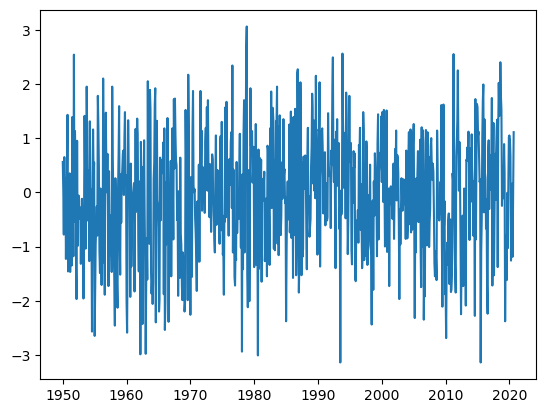

In [7]:
plt.plot(ds_index['time'],ds_index['nao'])

In [9]:
positive = ds_index['nao'].where(ds_index['nao']>0)
negative = ds_index['nao'].where(ds_index['nao']<0)
neutral = ds_index['nao'].where(ds_index['nao']==0)

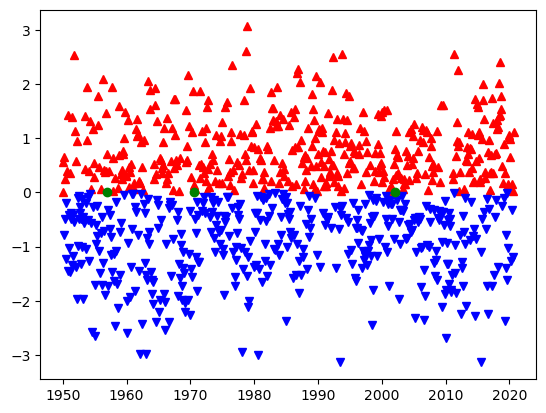

In [11]:
plt.plot(ds_index['time'],positive,'r^')
plt.plot(ds_index['time'],negative,'bv')
plt.plot(ds_index['time'],neutral,'go') ;

In [17]:
print('Positive Phase: ',positive.count(dim='time').values)
print('Neutral: ',neutral.count(dim='time').values)
print('Negative Phase: ',negative.count(dim='time').values)

counts=[positive.count(dim='time').values,
        neutral.count(dim='time').values,
        negative.count(dim='time').values]
print(counts)

Positive Phase:  422
Neutral:  3
Negative Phase:  424
[array(422), array(3), array(424)]


In [18]:
file_precip = '/home/dgray24/precip.mon.mean.nc'
ds_precip = xr.open_dataset(file_precip)
ds_precip

<xarray.Dataset>
Dimensions:  (lat: 72, lon: 144, time: 442)
Coordinates:
  * lat      (lat) float32 88.75 86.25 83.75 81.25 ... -83.75 -86.25 -88.75
  * lon      (lon) float32 1.25 3.75 6.25 8.75 11.25 ... 351.2 353.8 356.2 358.8
  * time     (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2015-10-01
Data variables:
    precip   (time, lat, lon) float32 ...
Attributes:
    Conventions:      COARDS
    title:            GPCP Version 2.2 Combined Precipitation Dataset (Final)
    platform:         Observation
    source:           GPCP Polar Satellite Precipitation Data Centre - Emissi...
    version:          V2.2
    comments:         Please redownload if you obtained this file before Aug ...
    Acknowledgement:  \n,Please cite the original source of the data.\nPlease...
    history:          Converted from netCDF3 to chunked, deflated NetCDF4 Aug...
    dataset_title:    Global Precipitation Analysis (GPCP)
    documentation:    https://www.esrl.noaa.gov/psd/data/gridded/data.gpcp.html
    References:       https://www.esrl.noaa.gov/psd/data/gridded/data.gpcp.html

In [19]:
da_precip = ds_precip.precip.sel(time=slice(ds_index['time'][0],ds_index['time'][-1]))
da_precip

<xarray.DataArray 'precip' (time: 442, lat: 72, lon: 144)>
[4582656 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 88.75 86.25 83.75 81.25 ... -83.75 -86.25 -88.75
  * lon      (lon) float32 1.25 3.75 6.25 8.75 11.25 ... 351.2 353.8 356.2 358.8
  * time     (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2015-10-01
Attributes:
    long_name:     Average Monthly Rate of Precipitation
    valid_range:   [  0. 100.]
    units:         mm/day
    precision:     32767
    var_desc:      Precipitation
    dataset:       GPCP Version 2.2 Combined Precipitation Dataset
    level_desc:    Surface
    statistic:     Mean
    parent_stat:   Mean
    actual_range:  [ 0.      47.07601]

In [20]:
da_climo = da_precip.groupby('time.month').mean()
da_anoms = da_precip.groupby('time.month')-da_climo
da_anoms

<xarray.DataArray 'precip' (time: 442, lat: 72, lon: 144)>
array([[[ 0.3011943 ,  0.2552034 ,  0.26988107, ...,  0.24876434,
          0.26860404,  0.3245279 ],
        [ 0.35512424,  0.35881925,  0.29891342, ...,  0.32621682,
          0.35010532,  0.36415642],
        [ 0.44589043,  0.4071505 ,  0.3408506 , ...,  0.42296702,
          0.37082195,  0.41296068],
        ...,
        [-0.02303834, -0.02222047, -0.02668586, ..., -0.03533126,
         -0.03199311, -0.02647801],
        [-0.01962823, -0.02162275, -0.02301094, ..., -0.02927271,
         -0.03034357, -0.0243149 ],
        [-0.03194252, -0.04831706, -0.05069653, ..., -0.04328405,
         -0.03298864, -0.02728255]],

       [[ 0.6163507 ,  0.64637977,  0.61005586, ...,  0.6720065 ,
          0.61618435,  0.6028429 ],
        [ 0.7155361 ,  0.7123435 ,  0.7167437 , ...,  0.64851296,
          0.71538377,  0.686894  ],
        [ 0.6705663 ,  0.7232049 ,  0.7440723 , ...,  0.6543975 ,
          0.6545057 ,  0.6577517 ],
...
        [-0.14008304, -0.1168109 , -0.10910973, ..., -0.22984657,
         -0.22460088, -0.18830734],
        [-0.31007355, -0.32419607, -0.27627963, ..., -0.3442487 ,
         -0.3216044 , -0.2705661 ],
        [-0.3437778 , -0.3028708 , -0.27872494, ..., -0.32627106,
         -0.32085082, -0.32867348]],

       [[-0.05507118, -0.06431645, -0.04645598, ..., -0.01212221,
         -0.03593767, -0.07025445],
        [ 0.23310405,  0.21986985,  0.16831195, ...,  0.29926986,
          0.28030676,  0.23270863],
        [ 0.2399692 ,  0.27034616,  0.24322772, ...,  0.33268946,
          0.32193983,  0.27999204],
        ...,
        [-0.07517524, -0.07082073, -0.04260015, ..., -0.14952406,
         -0.12327052, -0.1078621 ],
        [-0.10038565, -0.10802621, -0.12990059, ..., -0.166105  ,
         -0.1508627 , -0.1506502 ],
        [-0.13867357, -0.15427735, -0.18443336, ..., -0.13130377,
         -0.13131899, -0.21159334]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 88.75 86.25 83.75 81.25 ... -83.75 -86.25 -88.75
  * lon      (lon) float32 1.25 3.75 6.25 8.75 11.25 ... 351.2 353.8 356.2 358.8
  * time     (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2015-10-01
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 12 ... 12 1 2 3 4 5 6 7 8 9 10

In [21]:
positive_precip = da_anoms.sel(time=positive.dropna(dim='time')['time']).mean(dim='time')
negataive_precip = da_anoms.sel(time=negative.dropna(dim='time')['time']).mean(dim='time')
neutral_precip = da_anoms.sel(time=neutral.dropna(dim='time')['time']).mean(dim='time')

comp_precip = [positive_precip,negative_precip,neutral_precip]
comp_precip

KeyError: "not all values found in index 'time'"

In [ ]:
labels=['Positive','Neutral', 'Negative']
clevs = np.arange(-2.0,2.1,0.25)
fig, axs = plt.subplots(nrows=3,ncols=1,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(8.5,11))

axs = axs.flatten()
for i,nao in enumerate(comp_precip):
        data = comp_precip[i]
        data,lons = add_cyclic_point(data,coord=comp_precip[i]['lon'])
        cs=axs[i].contourf(lons,comp_precip[i]['lat'],data,clevs,
                          transform = ccrs.PlateCarree(),
                          cmap='BrBG',extend='both')
        
        axs[i].set_xticks(np.arange(-180,181,60), crs=ccrs.PlateCarree())
        lon_formatter = cticker.LongitudeFormatter()
        axs[i].xaxis.set_major_formatter(lon_formatter)
        axs[i].set_yticks(np.arange(-90,91,30), crs=ccrs.PlateCarree())
        lat_formatter = cticker.LatitudeFormatter()
        axs[i].yaxis.set_major_formatter(lat_formatter)
        
        axs[i].set_title(labels[i]+' ('+str(counts[i])+')')
        axs[i].coastlines()
        
fig.subplots_adjust(bottom=0.25, top=0.9, left=0.05, right=0.95,
                    wspace=0.1, hspace=0.5)

cbar_ax = fig.add_axes([0.25, 0.18, 0.5, 0.012])
cbar = fig.colorbar(cs,cax=cbar_ax,orientation='horizontal',label='mm/day')
plt.suptitle('Composite Precipitation Anomalies during NAO') ;